<a href="https://colab.research.google.com/github/drOluOla/Lloyds_DA_AI_Scientist_Take_Home/blob/main/Lloyds_Take_Home_Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
Actionable insights into customer savings behavior are crucial for driving business growth and enhancing customer relationships. This analysis leverages statistical and machine learning models to identify key savings drivers and predict future behavior, offering a path to optimize deposit strategies and personalize customer engagement. Ethical considerations and regulatory compliance (Equality Law, FCA Principles, UK GDPR) are integrated throughout the process to ensure responsible and trustworthy AI implementation. The findings highlight that current financial behavior is a stronger predictor of future savings than demographics, supporting ethical, behavior-based modeling approaches.

# **Problem Statement**
Analyse customer saving behavior to identify key drivers and predict future savings, aiming to deepen customer relationships through behavioral insights. This analysis must adhere to ethical guidelines, relevant laws (Equality Law, FCA Principles), and UK GDPR, particularly concerning special category data.

**Business Objectives:**
- Deepen customer relationships through behavioral insights.

**Machine Learning/Statistical Model Objective:**
- Develop a regression model to predict future customer savings.

# **Methodology**

To mitigate the bias in identified in the previous section, I follow guidance provided by ICO vs FCA on processes for mitigating bias using both pre-processing and post-processing approaches. The work is structured into key tickets, managed iteratively via a Kanban board (image below), with subtasks detailed in the [GitHub project link](https://github.com/users/drOluOla/projects/2).

![](https://drive.google.com/uc?export=view&id=121BTN4Nhs75LCoV9K3zbkLwmYvOqDCNO)

**Libraries and Tools (to be used across tickets):**
-   Scikit learn
-   Stats Model (For Statistical Modelling)
-   Seaborn and Matplotlib (For visualisation)
-   Fairlearn (Fairness analysis)
-   Computer Assisted Coding (for code completion)

## **Implementation**

### **Package Installation**

In [133]:
!pip install openai-agents


In [134]:
import os
from google.colab import drive, userdata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from typing import Dict, Optional
from dotenv import load_dotenv
import logging
import argparse
import os
import json
from math import isfinite
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

from agents import Agent, Runner

### **Global Variables**

In [135]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths to the files in Google Drive
data_path = "/content/drive/My Drive/Job_2025/Lloyds/dataset/savings_customers_data_v1 8.xlsx"
dictionary_path = "/content/drive/My Drive/Job_2025/Lloyds/dataset/data_dictionary_v1 8.xlsx"

data_exists = os.path.exists(data_path)
dictionary_exists = os.path.exists(dictionary_path)

# Verify paths to data and dictionary exist
if data_exists and dictionary_exists:
    print("Both data and dictionary files found!")
else:
    if not data_exists:
        print(f"Error: Data file not found at {data_path}")
    if not dictionary_exists:
        print(f"Error: Dictionary file not found at {dictionary_path}")
    print("Please ensure both data and dictionary files are in the correct Google Drive location and the paths are accurate.")


# Verify API Key has been correctly setup for Question 6
openai_api_key = userdata.get('OPENAI_API_KEY')

instructions = "You are a helpful econometric assistant. Reply in a 7-word clear and simple sentence"
agent = Agent(name="Assistant", instructions=instructions)

if openai_api_key:
    os.environ["OPENAI_API_KEY"] = openai_api_key
    result = await Runner.run(agent, "How can Lloyds Bank ensure fairness and reduce bias using saving habits?")
    print(result.final_output)
else:
    print("Please set the OPENAI_API_KEY environment variable in Colab Secrets.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Both data and dictionary files found!
Analyze data, adjust algorithms, monitor outcomes, educate customers.


### **Utilities**

In [136]:
class Utilities:
    """
    A class for utility functions, including data visualization.
    """
    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.data = data
        self.target_variable = target_variable

    def plot_target_distribution(self, output_dir: Path) -> None:
        """
        Plots the distribution and box plot of the target variable.
        """
        if self.target_variable in self.data.columns:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].hist(self.data[self.target_variable], bins=30, alpha=0.7)
            axes[0].set_title('Target Distribution')
            axes[1].boxplot(self.data[self.target_variable])
            axes[1].set_title('Target Box Plot')
            plt.tight_layout()
            plt.savefig(output_dir / 'target_variable_distribution.png', dpi=200, bbox_inches='tight')
            plt.show()
        else:
            print(f"Target variable '{self.target_variable}' not found in the data.")

    def plot_correlation_matrix(self, output_dir: Path) -> None:
        """
        Plots the correlation matrix of numeric variables.
        """
        numeric_data = self.data.select_dtypes(include=[np.number])
        correlation_matrix = numeric_data.corr()
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.savefig(output_dir / 'correlation_matrix.png', dpi=200, bbox_inches='tight')
        plt.show()

    def plot_categorical_vs_target(self, output_dir: Path, num_cols_to_plot: int = 3) -> None:
        """
        Plots box plots of the target variable against categorical variables.
        """
        categorical_columns = self.data.select_dtypes(include=['object', 'category']).columns
        for col in categorical_columns[:num_cols_to_plot]:
            if self.target_variable in self.data.columns:
                plt.figure(figsize=(8, 5))
                sns.boxplot(data=self.data, x=col, y=self.target_variable)
                plt.title(f'{self.target_variable} by {col}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(output_dir / f'{col}_vs_target.png', dpi=200, bbox_inches='tight')
                plt.show()
            else:
                print(f"Target variable '{self.target_variable}' not found in the data.")

    def plot_all_distributions(self, output_dir: Path, num_categorical_cols: int = 3) -> None:
        """
        Generates a composite figure with target distribution, correlation matrix,
        and selected categorical vs. target variable plots.
        """
        # Determine the number of rows needed: 1 for target, 1 for correlation,
        # and ceil(num_categorical_cols / 2) for categorical plots (2 columns).
        num_categorical_rows = (num_categorical_cols + 1) // 2
        num_rows = 2 + num_categorical_rows
        fig = plt.figure(figsize=(12, 4 * num_rows))
        gs = fig.add_gridspec(num_rows, 2) # Always 2 columns

        # Target Distribution
        if self.target_variable in self.data.columns:
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.hist(self.data[self.target_variable], bins=30, alpha=0.7)
            ax1.set_title('Target Distribution')

            ax2 = fig.add_subplot(gs[0, 1])
            ax2.boxplot(self.data[self.target_variable])
            ax2.set_title('Target Box Plot')
        else:
             print(f"Target variable '{self.target_variable}' not found in the data.")


        # Correlation Matrix
        numeric_data = self.data.select_dtypes(include=[np.number])
        correlation_matrix = numeric_data.corr()
        ax3 = fig.add_subplot(gs[1, :]) # Span across both columns
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, ax=ax3)
        ax3.set_title('Correlation Matrix')

        # Categorical vs. Target Plots
        categorical_columns = self.data.select_dtypes(include=['object', 'category']).columns
        for i, col in enumerate(categorical_columns[:num_categorical_cols]):
            row_index = 2 + i // 2
            col_index = i % 2
            if self.target_variable in self.data.columns:
                ax = fig.add_subplot(gs[row_index, col_index])
                sns.boxplot(data=self.data, x=col, y=self.target_variable, ax=ax)
                ax.set_title(f'{self.target_variable} by {col}')
                plt.xticks(rotation=45)
            else:
                print(f"Target variable '{self.target_variable}' not found in the data.")

        plt.tight_layout()
        plt.savefig(output_dir / 'all_distributions_composite.png', dpi=200, bbox_inches='tight')
        plt.show()

### **Task 1: Clean Dataset & Conduct Descriptive Analysis**
Sub-tasks

- Load, clean and perform initial exploration
- Perform data transformations and feature engineering as needed
- Generate descriptive statistics for all variables
- Create visualizations (plots) to explore variable distributions and relationships



#### **Code**

In [137]:
import pandas as pd
from pathlib import Path
from typing import Optional
import logging

class LBGDataLoader:
    """
    A class to load customer savings data and its dictionary.
    """
    def __init__(self, data_path: str, dictionary_path: str):
        self.data_path: Path = Path(data_path)
        self.dictionary_path: Path = Path(dictionary_path)
        self.raw_data: Optional[pd.DataFrame] = None
        self.data_dictionary: Optional[pd.DataFrame] = None
        self.target_variable = 'annual_net_savings_lbg'
        #self.results = {}

    def load_data(self) -> None:
        """
        Loads the data and data dictionary from the specified paths.
        """
        try:
            self.raw_data = pd.read_excel(self.data_path)
            self.data_dictionary = pd.read_excel(self.dictionary_path)
            print(f"✓ Loaded {len(self.raw_data)} records with {len(self.raw_data.columns)} columns")
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

In [138]:
# Extend the base class to include initial exploration and cleaning the dataset
class LBGDataProcessor(LBGDataLoader):
    """
    A class to process the customer savings data.
    """
    def __init__(self, data_path: str, dictionary_path: str):
         super().__init__(data_path, dictionary_path)
         self.clean_data: Optional[pd.DataFrame] = None

    def initial_data_exploration(self) -> None:
        print("="*50, "DATA EXPLORATION", "="*50)
        print(f"Shape: {self.raw_data.shape}")
        print(f"Columns: {list(self.raw_data.columns)}")

        missing_data_count = self.raw_data.isnull().sum()
        missing_data_percentage = (missing_data_count / len(self.raw_data)) * 100
        missing_data_df = pd.DataFrame({'Count': missing_data_count, 'Percentage': missing_data_percentage})
        print("\nMissing Values:")
        display(missing_data_df[missing_data_df['Count'] > 0])

        print("\nBasic Statistics:")
        display(self.raw_data.describe())
        print(f"\nDuplicates: {self.raw_data.duplicated().sum()}")

    def clean_and_preprocess_data(self) -> None:
        print("="*50, "DATA CLEANING", "="*50)
        self.clean_data = self.raw_data.copy()

        missing_values_before = self.clean_data.isnull().sum().sum()
        numeric_columns = self.clean_data.select_dtypes(include=[np.number]).columns
        categorical_columns = self.clean_data.select_dtypes(include=['object']).columns

        # Handle missing values for numeric columns
        for col in numeric_columns:
            missing_percentage = (self.clean_data[col].isnull().sum() / len(self.clean_data)) * 100
            if 0 < missing_percentage < 5:
                self.clean_data[col].fillna(self.clean_data[col].median(), inplace=True)

        # Handle missing values for categorical columns
        for col in categorical_columns:
            missing_percentage = (self.clean_data[col].isnull().sum() / len(self.clean_data)) * 100
            if 0 < missing_percentage < 5:
                mode_value = self.clean_data[col].mode()[0] if not self.clean_data[col].mode().empty else 'Unknown'
                self.clean_data[col].fillna(mode_value, inplace=True)

        # Remove duplicates and handle outliers
        self.clean_data.drop_duplicates(inplace=True)
        self._handle_outliers()
        self._engineer_features()

        # Handle inf values (replace with nan then handle)
        numeric_columns = self.clean_data.select_dtypes(include=[np.number]).columns
        self.clean_data[numeric_columns] = self.clean_data[numeric_columns].replace([np.inf, -np.inf], np.nan)

        # Handle inf values (replace with nan then handle)
        numeric_columns = self.clean_data.select_dtypes(include=[np.number]).columns
        inf_value_count = 0
        for col in numeric_columns:
            inf_mask = np.isinf(self.clean_data[col])
            inf_value_count += inf_mask.sum()
            if inf_mask.any():
                # Replace inf with nan, then with median
                self.clean_data.loc[inf_mask, col] = np.nan
                median_value = self.clean_data[col].median()
                self.clean_data[col].fillna(median_value, inplace=True)


        print(f"Missing values: {missing_values_before} → {self.clean_data.isnull().sum().sum()}")
        print(f"Final shape: {self.clean_data.shape}")


    def _handle_outliers(self) -> None:
        numeric_columns = self.clean_data.select_dtypes(include=[np.number]).columns
        outlier_count = 0
        for col in numeric_columns:
            Q1, Q3 = self.clean_data[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            outliers = ((self.clean_data[col] < lower_bound) | (self.clean_data[col] > upper_bound)).sum()
            if outliers > 0:
                self.clean_data[col] = np.clip(self.clean_data[col], lower_bound, upper_bound)
                outlier_count += outliers
        print(f"Capped {outlier_count} outliers")

    def _engineer_features(self) -> None:
        features_added_count = 0
        if 'annual_income' in self.clean_data.columns and self.target_variable in self.clean_data.columns:
            self.clean_data['savings_rate'] = (
                self.clean_data[self.target_variable] /
                self.clean_data['annual_income'].replace(0, np.nan)
            )
            features_added_count += 1

        if 'age' in self.clean_data.columns:
            self.clean_data['age_group'] = pd.cut(
                self.clean_data['age'], bins=[18, 25, 35, 45, 55, 100],
                labels=['18-25', '26-35', '36-45', '46-55', '55+']
            )
            features_added_count += 1
        print(f"Added {features_added_count} engineered features")


    def descriptive_analysis(self) -> None:
        print("="*50, "DESCRIPTIVE ANALYSIS", "="*50)
        output_dir = Path("analysis_outputs")
        output_dir.mkdir(exist_ok=True)

        print("Summary Statistics:")
        display(self.clean_data.describe())

        # Use the Utilities class for plotting
        utilities = Utilities(self.clean_data, self.target_variable)
        utilities.plot_all_distributions(output_dir)

✓ Loaded 30305 records with 15 columns
================================================== DATA EXPLORATION ==================================================
Shape: (30305, 15)
Columns: ['cust_unique_id', 'age', 'gender', 'ethnicity_group', 'geo_region', 'net_salary', 'other_income', 'observed_income', 'housing_spend', 'childcare_spend', 'gambling_spend', 'observed_surplus', 'credit_score', 'savings_bal_lbg', 'annual_net_savings_lbg']

Missing Values:


,Count,Percentage
other_income,4238,13.984491
housing_spend,7356,24.273222



Basic Statistics:


,cust_unique_id,age,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,savings_bal_lbg,annual_net_savings_lbg
count,30305.00000,30305.000000,30305.000000,26067.000000,30305.000000,22949.000000,30305.000000,30305.000000,30305.000000,3.030500e+04,30305.000000
mean,15153.00000,41.654182,56585.867472,13580.886176,69246.199349,24719.267675,593.375517,98.408160,51270.967701,8.405509e+05,21299.618218
std,8748.44429,15.444812,11794.832398,5862.046413,14708.576183,4325.260951,2528.447257,2881.362877,16050.305701,7.323375e+05,10018.424977
min,1.00000,4.000000,-1000.000000,0.000000,32518.450000,10573.570000,0.000000,0.000000,-408635.510000,0.000000e+00,0.000000
25%,7577.00000,29.000000,50407.530000,9962.795000,59196.380000,21605.140000,0.000000,0.000000,40242.040000,1.514217e+05,16891.130000
50%,15153.00000,42.000000,56643.520000,12716.980000,67338.610000,24603.170000,0.000000,0.000000,50093.010000,7.113819e+05,22870.700000
75%,22729.00000,55.000000,64805.760000,18749.150000,82136.110000,28155.700000,0.000000,0.000000,60232.450000,1.397923e+06,28352.660000
max,30305.00000,68.000000,104374.080000,29752.890000,131050.070000,42189.020000,17778.930000,448664.260000,128700.410000,3.615059e+06,42951.370000



Duplicates: 0
================================================== DATA CLEANING ==================================================
Capped 5624 outliers
Added 1 engineered features
Missing values: 11594 → 13312
Final shape: (30305, 16)
================================================== DESCRIPTIVE ANALYSIS ==================================================
Summary Statistics:


,cust_unique_id,age,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,savings_bal_lbg,annual_net_savings_lbg
count,30305.00000,30305.000000,30305.000000,26067.000000,30305.000000,22949.000000,30305.0,30305.0,30305.000000,3.030500e+04,30305.000000
mean,15153.00000,41.654182,57072.524388,13580.886176,69241.799032,24717.616227,0.0,0.0,51230.198056,8.405246e+05,21299.618218
std,8748.44429,15.444812,9763.581102,5862.046413,14693.009477,4318.795761,0.0,0.0,15602.143152,7.322466e+05,10018.424977
min,1.00000,4.000000,28810.185000,0.000000,32518.450000,11779.300000,0.0,0.0,10256.425000,0.000000e+00,0.000000
25%,7577.00000,29.000000,50407.530000,9962.795000,59196.380000,21605.140000,0.0,0.0,40242.040000,1.514217e+05,16891.130000
50%,15153.00000,42.000000,56643.520000,12716.980000,67338.610000,24603.170000,0.0,0.0,50093.010000,7.113819e+05,22870.700000
75%,22729.00000,55.000000,64805.760000,18749.150000,82136.110000,28155.700000,0.0,0.0,60232.450000,1.397923e+06,28352.660000
max,30305.00000,68.000000,86403.105000,29752.890000,116545.705000,37981.540000,0.0,0.0,90218.065000,3.267674e+06,42951.370000


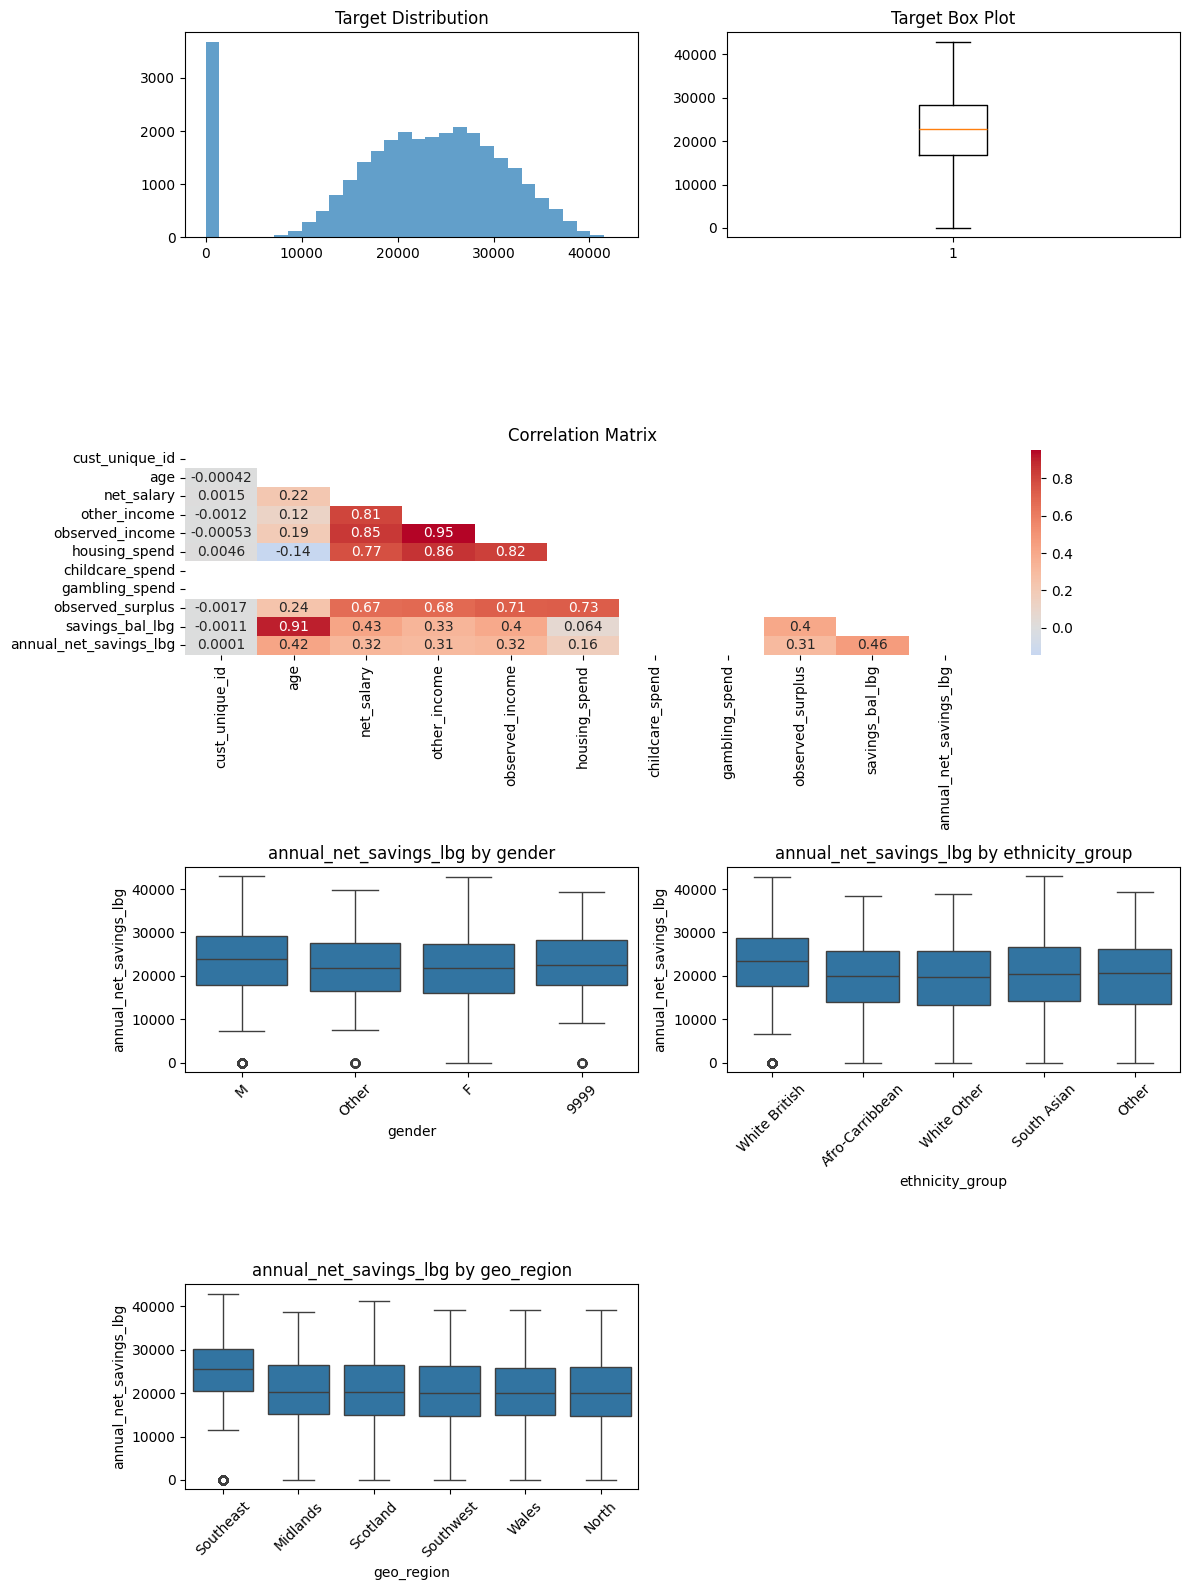

In [139]:
#run the codes above to test
data_processor = LBGDataProcessor(data_path, dictionary_path)
data_processor.load_data()
data_processor.initial_data_exploration()
data_processor.clean_and_preprocess_data()
data_processor.descriptive_analysis()

#### **Comment**

Task 1 focused on data cleaning and descriptive analysis. Upon loading, the dataset contained 30305 records and 15 columns. Initial exploration revealed missing values in `other_income` (13.98%) and `housing_spend` (24.27%), which were imputed for columns with less than 5% missingness. No duplicate rows were found. Outliers in numeric columns were capped at the 1.5*IQR bounds, affecting 5624 values. An `age_group` feature was engineered. The final cleaned data has a shape of (30305, 16), with some remaining missing values.

Descriptive analysis provided summary statistics (as displayed). Visualizations, including the target variable distribution, correlation matrix, and categorical vs. target variable box plots (as shown in the generated figures), offered insights into data characteristics and relationships.

>   - OLU To fix: Make sure the summary above makes sense.
    - Add rationale for dealing with missing data
    - Add rationale for outliers
    - Add rationale for feature engineering
    - Add observation of negative values
    - Add observation of break in constraint of minimum age required for opening account and with above point raising suspicion of validity of data source during collection.




### **Task 2: Create Statistical Models**
Sub-tasks
- Train the statistical model(s)
- Evaluate model performance using relevant metrics (e.g., R-squared, p-values)
- Interpret model coefficients and assess statistical significance


#### **Code**

In [142]:
class LBGModelBuilder:
    """
    A class to build and evaluate statistical and machine learning models.
    """
    def __init__(self, data: pd.DataFrame, target_variable: str):
        self.data = data
        self.target_variable = target_variable
        self.results = {}

    def build_statistical_models(self) -> None:
        print("="*50, "STATISTICAL MODELING", "="*50)

        if self.target_variable not in self.data.columns:
            print("Target variable not found. Skipping.")
            return

        # Prepare data
        model_data = self.data.copy()
        categorical_columns = model_data.select_dtypes(include=['object', 'category']).columns

        for col in categorical_columns:
            if col != self.target_variable:
                dummies = pd.get_dummies(model_data[col], prefix=col, drop_first=True)
                model_data = pd.concat([model_data, dummies], axis=1)
                model_data.drop(col, axis=1, inplace=True)

        y = model_data[self.target_variable]
        X = model_data.drop(self.target_variable, axis=1).select_dtypes(include=[np.number])

        # Clean data for OLS (remove inf/nan values)
        # Replace inf values with nan first
        # X = X.replace([np.inf, -np.inf], np.nan)
        # y = y.replace([np.inf, -np.inf], np.nan)

        # Remove rows with any nan/inf values
        combined_data = pd.concat([X, y], axis=1)
        combined_data = combined_data.dropna()

        if len(combined_data) == 0:
            print("No valid data remaining after cleaning inf/nan values")
            return

        X_clean = combined_data.iloc[:, :-1]  # All columns except last
        y_clean = combined_data.iloc[:, -1]   # Last column (target)

        # OLS Regression
        try:
            X_with_const = sm.add_constant(X_clean)
            ols_model = sm.OLS(y_clean, X_with_const).fit()
            print(f"OLS R²: {ols_model.rsquared:.4f}")

            # Residual diagnostics plot
            residuals = ols_model.resid
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))

            axes[0, 0].scatter(ols_model.fittedvalues, residuals, alpha=0.6)
            axes[0, 0].axhline(y=0, color='red', linestyle='--')
            axes[0, 0].set_title('Residuals vs Fitted')

            stats.probplot(residuals, dist="norm", plot=axes[0, 1])
            axes[0, 1].set_title('Q-Q Plot')

            axes[1, 0].hist(residuals, bins=20, alpha=0.7)
            axes[1, 0].set_title('Residual Distribution')

            axes[1, 1].scatter(ols_model.fittedvalues, np.abs(residuals), alpha=0.6)
            axes[1, 1].set_title('Scale-Location')

            plt.tight_layout()
            plt.savefig('analysis_outputs/ols_diagnostics.png', dpi=200, bbox_inches='tight')
            plt.show()

            # Store results
            self.results['ols_model'] = ols_model

            # Significant variables
            significant_vars = ols_model.pvalues[ols_model.pvalues < 0.05].sort_values()
            print(f"Significant variables (p < 0.05): {len(significant_vars)})")
            if len(significant_vars) > 0:
                print("\nSignificant predictors:")
                for var in significant_vars.index:
                    coef = ols_model.params[var]
                    pval = ols_model.pvalues[var]
                    print(f"- {var}: coef={coef:.3f}, p={pval:.4f}")
            else:
                print("No variables are statistically significant at p < 0.05.")

        except Exception as e:
            print(f"OLS model error: {e}")

================================================== STATISTICAL MODELING ==================================================
OLS R²: 0.2674


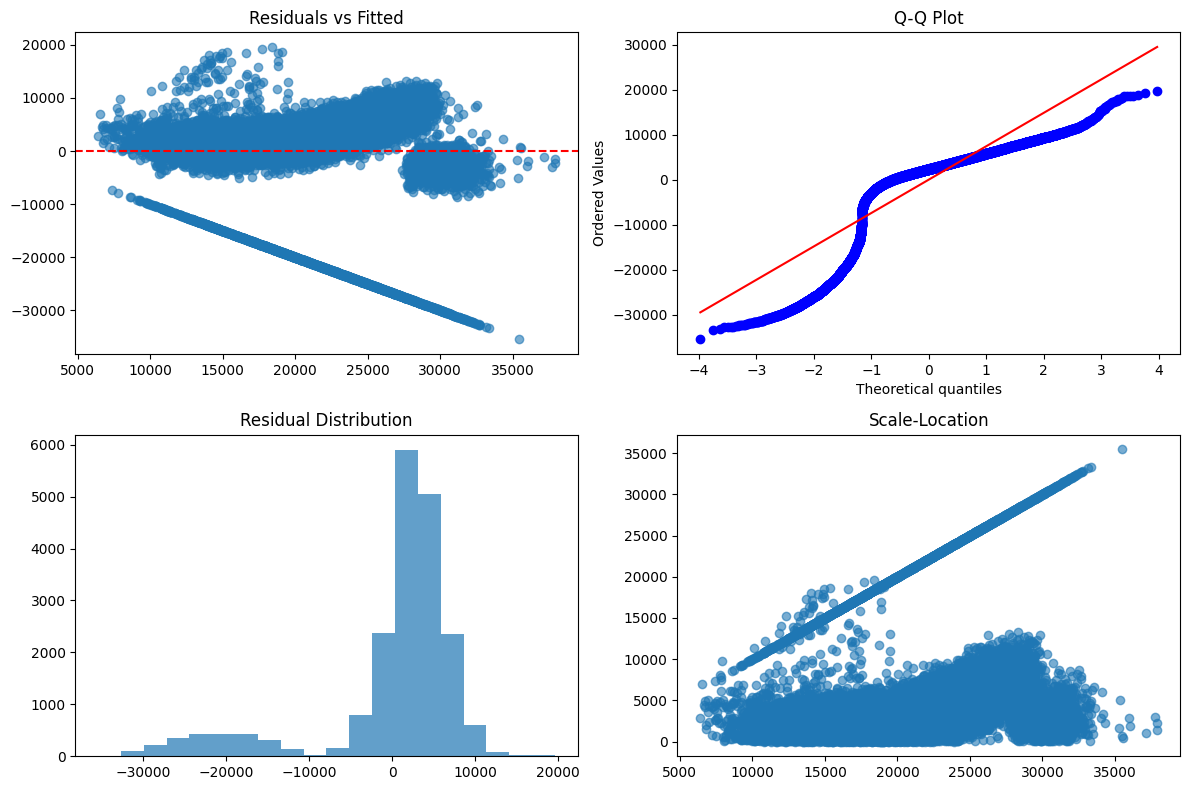

Significant variables (p < 0.05): 4)

Significant predictors:
- age: coef=193.231, p=0.0000
- childcare_spend: coef=-0.000, p=0.0000
- observed_surplus: coef=0.307, p=0.0000
- const: coef=1844.334, p=0.0202

Interpretation:
The above variables have robust statistically significant effects on annual net savings. Positive coefficients indicate a direct relationship, while negative coefficients indicate an inverse relationship.

Check if the direction and magnitude of effects make sense given domain knowledge (e.g., higher income should increase savings, higher spending may reduce savings).



In [143]:
# Run statistical models
if data_processor.clean_data is not None:
    model_builder = LBGModelBuilder(data_processor.clean_data, data_processor.target_variable)
    model_builder.build_statistical_models()
else:
    print("Data not loaded or cleaned. Please run previous steps.")

#### **Comment**

## **Conclusion**
Statistical modeling and machine learning applications in economic data analysis serve a fundamental purpose: advancing business objectives and maintaining competitive advantage. This assignment evaluates technical competencies in coding and data analytics; however, these capabilities must be understood within their broader business context.
Effective ML implementation requires clear alignment with defined business goals to demonstrate tangible value and practical applicability. Drawing from Lloyds Banking Group's 2025-26 strategic priorities, the following business objectives have been identified as relevant contexts for this savings prediction exercise:
Business Goals aligned with ML Objectives:

1. Deepening customer relationships through behavioral insights – Predictive models can identify high-propensity savers and inform targeted engagement strategies to increase depth of relationship (current: c.1% growth in H1 2025; 2026 target: c.3%) [page 6].
2. Optimizing deposit franchise economics – Understanding drivers of savings behavior supports pricing strategies and customer segmentation to improve deposit gross margins (H1 2025: 1.29%, up 16bps YoY) [page 16].
3. Supporting sustainable financing commitments – Identifying customers with capacity and propensity to save can inform targeting for green savings products aligned with the £30bn sustainable financing target by 2026 [page 6].
4. Enhancing capital-lite revenue growth – Predictive insights into savings patterns can support fee-based product cross-sell, contributing to the 50:50 NII:OOI revenue split target and >£1.5bn additional strategic revenues by 2026 [page 7].
5. Driving operational efficiency through automation – ML models can automate customer segmentation and propensity scoring, supporting the <50% cost-to-income ratio target and productivity improvements (>40% increase in customers served per FTE vs. 2021) [page 7,9,19].
6. Risk-aware portfolio management – Understanding the financial health indicators within savings behavior supports prudent lending decisions and maintaining robust asset quality (target AQR: c.25bps) [page 20].

This analysis demonstrates the technical approaches—data cleansing, statistical modeling, and machine learning—that would underpin such business applications, while also addressing critical considerations around model ethics, interpretability, and deployment suitability.